In [1]:
!pip install protobuf==3.20.0 --no-dependencies

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0


In [2]:
import os

# --- 1. Define Paths for Kaggle Input Directory ---
# This is the path Kaggle creates for your dataset.
# The dataset name is 'karyogram-cv-camp' and the top folder inside is '2025_Karyogram_CV_Camp'
base_path = '/kaggle/input/karyogram-cv-camp/2025_Karyogram_CV_Camp'
images_path = os.path.join(base_path, '24_chromosomes_object', 'images')
annotations_path = os.path.join(base_path, '24_chromosomes_object', 'annotations')
train_file = os.path.join(base_path, 'train.txt')

# --- 2. Run Verification Checks ---
print("--- Verifying Dataset Paths ---")

# Check if the main folders exist
print(f"Base folder exists: {os.path.exists(base_path)} -> {base_path}")
print(f"Images folder exists: {os.path.exists(images_path)}")
print(f"Annotations folder exists: {os.path.exists(annotations_path)}")
print(f"train.txt file exists: {os.path.exists(train_file)}")

# --- 3. Preview Contents ---
if os.path.exists(train_file):
    print("\n--- Previewing train.txt ---")
    try:
        with open(train_file, 'r') as f:
            lines = [f.readline().strip() for _ in range(5)]
        print("First 5 image names:", lines)
        print(" Verification successful! You can now proceed to preprocessing.")
    except Exception as e:
        print(f" Error reading train.txt: {e}")
else:
    print("\n Verification failed. Please check your dataset name and paths.")

--- Verifying Dataset Paths ---
Base folder exists: True -> /kaggle/input/karyogram-cv-camp/2025_Karyogram_CV_Camp
Images folder exists: True
Annotations folder exists: True
train.txt file exists: True

--- Previewing train.txt ---
First 5 image names: ['103064', '103071', '103072', '103081', '103082']
 Verification successful! You can now proceed to preprocessing.


In [3]:
import os
import cv2
import xml.etree.ElementTree as ET
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import shutil

# --- 1. Define Paths for Kaggle ---
# This is the verified input path from the previous cell
BASE_PATH = '/kaggle/input/karyogram-cv-camp/2025_Karyogram_CV_Camp'

# This is the writable output directory on Kaggle
OUTPUT_PATH = '/kaggle/working/processed_data'

IMAGE_SIZE = (128, 128)
MIN_CROP_DIMENSION = 10

# Clean up any previous runs to ensure a fresh start
if os.path.exists(OUTPUT_PATH):
    shutil.rmtree(OUTPUT_PATH)
    print(" Cleaned up previous processed_data folder.")

# --- 2. Read file list and create train/validation splits ---
train_file_list = os.path.join(BASE_PATH, 'train.txt')
with open(train_file_list, 'r') as f:
    all_train_names = [line.strip() for line in f]

train_names, val_names = train_test_split(all_train_names, test_size=0.2, random_state=42)

print(f" Total images for processing: {len(all_train_names)}")
print(f"   - Training set size: {len(train_names)}")
print(f"   - Validation set size: {len(val_names)}")

# --- 3. Define the main processing function ---
def process_and_save_images(image_names, set_name):
    """
    Processes a list of image names, extracts, cleans, and saves chromosome crops.
    """
    images_path = os.path.join(BASE_PATH, "24_chromosomes_object", "images")
    annotations_path = os.path.join(BASE_PATH, "24_chromosomes_object", "annotations")

    for image_name in tqdm(image_names, desc=f"Processing {set_name} set"):
        image_path = os.path.join(images_path, image_name + ".jpg")
        xml_path = os.path.join(annotations_path, image_name + ".xml")

        if not os.path.exists(image_path) or not os.path.exists(xml_path):
            continue

        image = cv2.imread(image_path)
        if image is None:
            continue
        
        try:
            tree = ET.parse(xml_path)
            root = tree.getroot()
        except ET.ParseError:
            continue

        for i, member in enumerate(root.findall('object')):
            try:
                label = member.find('name').text.strip().upper()
                bndbox = member.find('bndbox')
                xmin, ymin = int(bndbox.find('xmin').text), int(bndbox.find('ymin').text)
                xmax, ymax = int(bndbox.find('xmax').text), int(bndbox.find('ymax').text)
            except (AttributeError, ValueError):
                continue

            # Crop the chromosome
            cropped_chromosome = image[ymin:ymax, xmin:xmax]
            
            # Handle small or invalid crops
            if cropped_chromosome.size == 0 or cropped_chromosome.shape[0] < MIN_CROP_DIMENSION or cropped_chromosome.shape[1] < MIN_CROP_DIMENSION:
                continue

            # Create the destination directory in the /kaggle/working/ folder
            label_dir = os.path.join(OUTPUT_PATH, set_name, label)
            os.makedirs(label_dir, exist_ok=True)
            
            # Resize the valid crop
            resized_chromosome = cv2.resize(cropped_chromosome, IMAGE_SIZE)

            # Save the final, processed image
            save_filename = f"{image_name}_crop_{i}.png"
            save_path = os.path.join(label_dir, save_filename)
            cv2.imwrite(save_path, resized_chromosome)

# --- 4. Run the processing for both training and validation sets ---
process_and_save_images(train_names, "train")
process_and_save_images(val_names, "validation")

print("\n All preprocessing is complete! Your dataset is ready for model training in '/kaggle/working/processed_data'.")

 Total images for processing: 3750
   - Training set size: 3000
   - Validation set size: 750


Processing validation set: 100%|██████████| 750/750 [00:45<00:00, 16.47it/s]


 All preprocessing is complete! Your dataset is ready for model training in '/kaggle/working/processed_data'.


In [4]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import RandomFlip, RandomRotation, Rescaling, RandomZoom, RandomContrast
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os
import json
import numpy as np
from tensorflow.keras.optimizers import Adam


# Use the exact path found
MODEL_PATH = "/kaggle/input/model97/tensorflow2/v5_97/1/re_tune_best_model_01.h5"
          
try:
    model = load_model(MODEL_PATH)
    print("✅ Model loaded successfully from the input dataset!")
    # Now you can proceed to re-compile and continue training:
    # model.summary()
    # ... your re-compile and model.fit() code ...

except Exception as e:
    print(f"❌ Error loading model: {e}")


# --- 1. Re-Define Parameters and Paths ---
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
NUM_CLASSES = 24

# Paths point to the output from your preprocessing cell
train_path = "/kaggle/working/processed_data/train"
val_path = "/kaggle/working/processed_data/validation"

# --- 2. Re-Load Datasets ---
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path, labels='inferred', label_mode='categorical', image_size=IMAGE_SIZE,
    interpolation='nearest', batch_size=BATCH_SIZE, shuffle=True
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_path, labels='inferred', label_mode='categorical', image_size=IMAGE_SIZE,
    interpolation='nearest', batch_size=BATCH_SIZE, shuffle=False
)
class_names = train_ds.class_names
print("✅ Datasets re-loaded.")

# --- 3. Re-Calculate Class Weights ---
# This is required because the weights dictionary is not saved with the model
sample_counts = [len(os.listdir(os.path.join(train_path, c))) for c in class_names]
total_samples = sum(sample_counts)
class_weights = {}
for i, count in enumerate(sample_counts):
    class_weights[i] = total_samples / (NUM_CLASSES * count)
print("✅ Class weights re-calculated.")

# --- 4. Re-Define Data Pipeline (Scaling and Augmentation) ---
rescale = Rescaling(1./255)
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.15),
    RandomZoom(0.1),
    RandomContrast(0.1),
])

def prepare(ds, shuffle=False, augment=False):
    ds = ds.map(lambda x, y: (rescale(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
print("✅ Data pipeline re-prepared with augmentation.")

# --- 5. Re-Define Smart Callbacks ---
callbacks = [
    #EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ModelCheckpoint("re_tune_best_model.h5", monitor='val_loss', save_best_only=True), # Changed name to avoid overwriting
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]
print("✅ Callbacks re-defined.")




# Unfreeze more layers, for example, from index 50
base_model_layer = model.get_layer(index=1) # The MobileNetV2 layer is typically index 1
base_model_layer.trainable = True

# Optionally unfreeze even deeper layers (e.g., from layer 50)
fine_tune_at_new = 50 
for layer in base_model_layer.layers[:fine_tune_at_new]:
    layer.trainable = False 
print(f"✅ Unfroze all layers after index {fine_tune_at_new} for re-tuning.")

# Use an even smaller learning rate for this ultimate fine-tuning stage
ULTRA_FINE_TUNE_LR = 1e-5 

model.compile(
    optimizer=Adam(learning_rate=ULTRA_FINE_TUNE_LR),
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)
print(f"✅ Model re-compiled with a new learning rate of {ULTRA_FINE_TUNE_LR}")

# Assuming train_ds, val_ds, class_weights, and callbacks are available in the new session.
NEW_FINE_TUNE_EPOCHS = 50 # Define how many more epochs you want to train

print("\n🚀 Starting continued fine-tuning...")

# The initial_epoch should be 0 unless you are tracking total epochs across sessions.
# For simplicity and independent tracking, let's start the epoch counter at 0 for this new run.
history_continue = model.fit(
    train_ds,
    epochs=NEW_FINE_TUNE_EPOCHS, 
    validation_data=val_ds,
    class_weight=class_weights,
    callbacks=callbacks
)

print("\nModel re-training complete!")

# Save the final, newly trained model
model.save("final_chromosome_classifier_re_tuned.h5")
print("\nFinal re-tuned model saved to final_chromosome_classifier_re_tuned.h5")

2025-11-27 08:00:57.623328: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764230458.133158      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764230458.366557      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1764230480.772143      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764230480.772849      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:

✅ Model loaded successfully from the input dataset!
Found 137645 files belonging to 24 classes.
Found 34410 files belonging to 24 classes.
✅ Datasets re-loaded.
✅ Class weights re-calculated.
✅ Data pipeline re-prepared with augmentation.
✅ Callbacks re-defined.
✅ Unfroze all layers after index 50 for re-tuning.
✅ Model re-compiled with a new learning rate of 1e-05

🚀 Starting continued fine-tuning...
Epoch 1/50


I0000 00:00:1764230517.747135      70 service.cc:148] XLA service 0x7a76440024c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764230517.748765      70 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764230517.748789      70 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764230520.618238      70 cuda_dnn.cc:529] Loaded cuDNN version 90300


   4/4302 ━━━━━━━━━━━━━━━━━━━━ 3:23 47ms/step - accuracy: 0.9622 - loss: 0.1220

I0000 00:00:1764230532.633680      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4302/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9722 - loss: 0.0961

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 341s 70ms/step - accuracy: 0.9722 - loss: 0.0961 - val_accuracy: 0.9709 - val_loss: 0.1091 - learning_rate: 1.0000e-05
Epoch 2/50
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 283s 66ms/step - accuracy: 0.9706 - loss: 0.1017 - val_accuracy: 0.9697 - val_loss: 0.1098 - learning_rate: 1.0000e-05
Epoch 3/50
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 277s 64ms/step - accuracy: 0.9705 - loss: 0.1025 - val_accuracy: 0.9700 - val_loss: 0.1108 - learning_rate: 1.0000e-05
Epoch 4/50
4300/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9711 - loss: 0.0996
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 274s 64ms/step - accuracy: 0.9711 - loss: 0.0996 - val_accuracy: 0.9704 - val_loss: 0.1097 - learning_rate: 1.0000e-05
Epoch 5/50
4301/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9736 - loss: 0.0931

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 275s 64ms/step - accuracy: 0.9736 - loss: 0.0931 - val_accuracy: 0.9715 - val_loss: 0.1058 - learning_rate: 2.0000e-06
Epoch 6/50
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 274s 64ms/step - accuracy: 0.9752 - loss: 0.0901 - val_accuracy: 0.9719 - val_loss: 0.1059 - learning_rate: 2.0000e-06
Epoch 7/50
4301/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9738 - loss: 0.0895

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 274s 64ms/step - accuracy: 0.9738 - loss: 0.0895 - val_accuracy: 0.9718 - val_loss: 0.1057 - learning_rate: 2.0000e-06
Epoch 8/50
4300/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9746 - loss: 0.0895

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 274s 64ms/step - accuracy: 0.9746 - loss: 0.0895 - val_accuracy: 0.9720 - val_loss: 0.1046 - learning_rate: 2.0000e-06
Epoch 9/50
4301/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9749 - loss: 0.0875

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 278s 64ms/step - accuracy: 0.9749 - loss: 0.0875 - val_accuracy: 0.9726 - val_loss: 0.1043 - learning_rate: 2.0000e-06
Epoch 10/50
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 280s 65ms/step - accuracy: 0.9756 - loss: 0.0851 - val_accuracy: 0.9723 - val_loss: 0.1055 - learning_rate: 2.0000e-06
Epoch 11/50
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 281s 65ms/step - accuracy: 0.9756 - loss: 0.0855 - val_accuracy: 0.9720 - val_loss: 0.1054 - learning_rate: 2.0000e-06
Epoch 12/50
4300/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9752 - loss: 0.0858
Epoch 12: ReduceLROnPlateau reducing learning rate to 3.999999989900971e-07.
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 279s 65ms/step - accuracy: 0.9752 - loss: 0.0858 - val_accuracy: 0.9724 - val_loss: 0.1048 - learning_rate: 2.0000e-06
Epoch 13/50
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 281s 65ms/step - accuracy: 0.9756 - loss: 0.0853 - val_accuracy: 0.9723 - val_loss: 0.1047 - learning_rate: 4.0000e-07
Epoch 14/50
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 280s

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 280s 65ms/step - accuracy: 0.9761 - loss: 0.0822 - val_accuracy: 0.9727 - val_loss: 0.1042 - learning_rate: 1.6000e-08
Epoch 20/50
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 322s 65ms/step - accuracy: 0.9761 - loss: 0.0829 - val_accuracy: 0.9727 - val_loss: 0.1043 - learning_rate: 1.6000e-08
Epoch 21/50
4301/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9761 - loss: 0.0830
Epoch 21: ReduceLROnPlateau reducing learning rate to 3.1999999094978194e-09.
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 278s 65ms/step - accuracy: 0.9761 - loss: 0.0830 - val_accuracy: 0.9726 - val_loss: 0.1043 - learning_rate: 1.6000e-08
Epoch 22/50
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 280s 65ms/step - accuracy: 0.9761 - loss: 0.0846 - val_accuracy: 0.9726 - val_loss: 0.1043 - learning_rate: 3.2000e-09
Epoch 23/50
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 277s 64ms/step - accuracy: 0.9758 - loss: 0.0852 - val_accuracy: 0.9726 - val_loss: 0.1043 - learning_rate: 3.2000e-09
Epoch 24/50
4301/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 

4302/4302 ━━━━━━━━━━━━━━━━━━━━ 277s 64ms/step - accuracy: 0.9760 - loss: 0.0816 - val_accuracy: 0.9725 - val_loss: 0.1042 - learning_rate: 1.2800e-10
Epoch 30/50
4300/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9749 - loss: 0.0878
Epoch 30: ReduceLROnPlateau reducing learning rate to 2.559999712214989e-11.
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 280s 65ms/step - accuracy: 0.9749 - loss: 0.0878 - val_accuracy: 0.9727 - val_loss: 0.1043 - learning_rate: 1.2800e-10
Epoch 31/50
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 277s 64ms/step - accuracy: 0.9765 - loss: 0.0841 - val_accuracy: 0.9726 - val_loss: 0.1042 - learning_rate: 2.5600e-11
Epoch 32/50
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 277s 64ms/step - accuracy: 0.9770 - loss: 0.0805 - val_accuracy: 0.9727 - val_loss: 0.1043 - learning_rate: 2.5600e-11
Epoch 33/50
4300/4302 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9760 - loss: 0.0817
Epoch 33: ReduceLROnPlateau reducing learning rate to 5.119999563207856e-12.
4302/4302 ━━━━━━━━━━━━━━━━━━━━ 277s 64ms/s


Model re-training complete!

Final re-tuned model saved to final_chromosome_classifier_re_tuned.h5


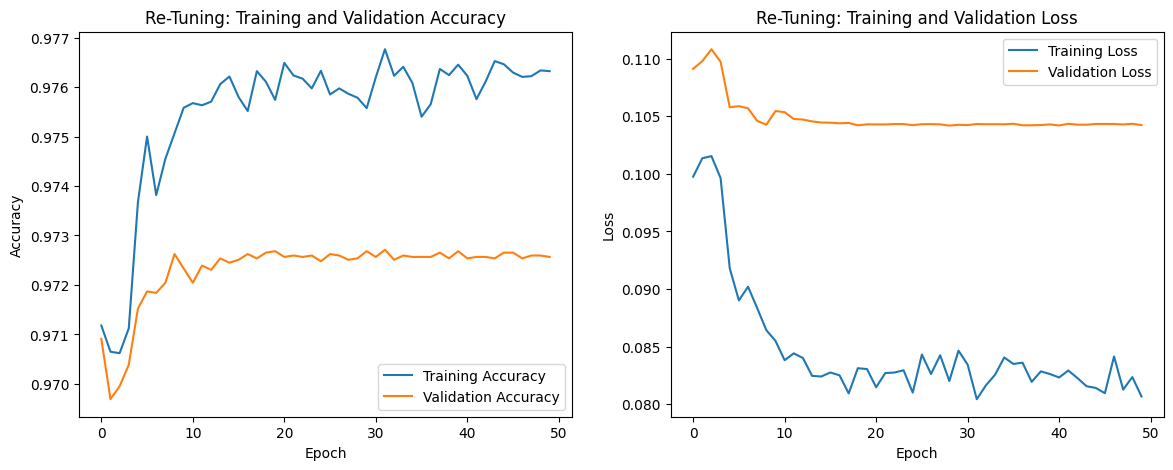


--- Final Evaluation ---
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.9723 - loss: 0.1016
Final Validation Accuracy after re-tuning: 97.26%
Final Validation Loss after re-tuning: 0.1042


In [5]:
import matplotlib.pyplot as plt

# Extract history from the final training run
acc = history_continue.history['accuracy']
val_acc = history_continue.history['val_accuracy']
loss = history_continue.history['loss']
val_loss = history_continue.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))

# --- Plot Accuracy ---
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Re-Tuning: Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# --- Plot Loss ---
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Re-Tuning: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

# --- Evaluate and Final Save ---
print("\n--- Final Evaluation ---")
# Evaluate the model on the validation set after the final run
loss, accuracy = model.evaluate(val_ds, verbose=1)
print(f"Final Validation Accuracy after re-tuning: {accuracy*100:.2f}%")
print(f"Final Validation Loss after re-tuning: {loss:.4f}")

# The model was already saved in the previous cell, but this confirms the result.

In [6]:
import os

# The base path of your retune01 input dataset
search_path = '/kaggle/input/model97'
found_files = []

print(f"--- Searching for .h5 model files in: {search_path} ---")

# Walk through the directory tree
for root, dirs, files in os.walk(search_path):
    for file in files:
        # Check for common Keras save file extensions
        if file.endswith('.h5') or file.endswith('.hdf5'):
            full_path = os.path.join(root, file)
            found_files.append(full_path)
            print(f"✅ FOUND: {full_path}")

if not found_files:
    print("❌ No .h5 files found in the dataset 'retune01'. Please ensure the model was committed to this dataset.")
else:
    print("\n--- Search Complete. Copy one of the 'FOUND' paths above for your MODEL_PATH variable. ---")

--- Searching for .h5 model files in: /kaggle/input/model97 ---
✅ FOUND: /kaggle/input/model97/tensorflow2/v5_97/1/re_tune_best_model_01.h5

--- Search Complete. Copy one of the 'FOUND' paths above for your MODEL_PATH variable. ---
